# Importing and Loading Data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
%matplotlib inline

train_data = pd.read_csv(r'C:\Users\Xu Chenyu\Desktop\Project\prudential-life-insurance-assessment\train.csv')
test_data = pd.read_csv(r'C:\Users\Xu Chenyu\Desktop\Project\prudential-life-insurance-assessment\test.csv')
all_data = train_data.append(test_data, sort=True)

# Data preprocessing

In [2]:
# # BMI, Ins_Age

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

# ax = sns.boxplot(x = "Response", y = "BMI_Age", data = all_data, palette = "Set3")
# ax = sns.swarmplot(x = "Response", y = "BMI_Age", data = all_data, color = ".25")

In [3]:
# Medical_Keywords

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Medical_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

In [4]:
# 将字符串型变量Product_Info_2进行拆分

all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]

all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

## Missing values

### Deletion

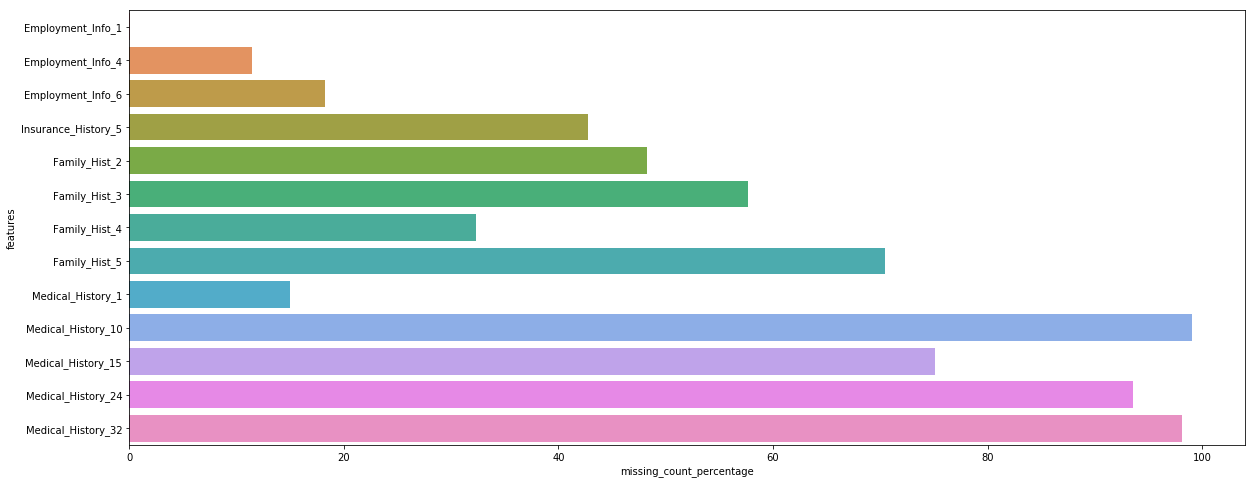

In [5]:
# 可视化缺失值占比

missing = train_data.isnull().sum()[train_data.isnull().sum() != 0]
missing = pd.DataFrame(missing.reset_index())
missing.rename(columns = {'index': 'features', 0: 'missing_count'}, inplace = True)
missing['missing_count_percentage'] = ((missing['missing_count']) / 59381) * 100 # 59381 -- row number
plt.figure(figsize = (20, 8))
g = sns.barplot(x = missing['missing_count_percentage'], y = missing['features'], data = missing)

In [6]:
from sklearn import preprocessing

# 丢弃缺失值过多的特征
columns_to_drop = ['Id', 'Medical_History_32', 'Medical_History_24', 'Medical_History_15', 'Medical_History_10','Family_Hist_5']

all_data.drop(columns_to_drop, axis = 1, inplace = True)

### Imputation

In [7]:
all_data['Employment_Info_1'].fillna(all_data['Employment_Info_1'].mean(), inplace = True)
all_data['Employment_Info_4'].fillna(all_data['Employment_Info_1'].mean(), inplace = True)
all_data['Employment_Info_6'].fillna(all_data['Employment_Info_6'].mean(), inplace = True)
all_data['Insurance_History_5'].fillna(all_data['Insurance_History_5'].mean(), inplace = True)
all_data['Family_Hist_2'].fillna(all_data['Family_Hist_2'].mean(), inplace = True)
all_data['Family_Hist_3'].fillna(all_data['Family_Hist_3'].mean(), inplace = True)
all_data['Family_Hist_4'].fillna(all_data['Family_Hist_4'].mean(), inplace = True)
all_data['Medical_History_1'].fillna(all_data['Medical_History_1'].median(), inplace = True)

## Scaling

### Scaling features to range -- MinMaxScaler

In [8]:
def min_max_scaler(x):
    all_data[x] = (all_data[x] - all_data[x].min())/(all_data[x].max() - all_data[x].min())

In [9]:
min_max_scaler('Medical_History_2')
min_max_scaler('Medical_Keywords_Count')

### Scaling data with outliers -- RobustScaler

In [10]:
from sklearn.preprocessing import RobustScaler

tmp = np.array(all_data['Medical_History_1'])
tmp_robust = RobustScaler().fit_transform(tmp.reshape(-1, 1))
tmp_robust = pd.DataFrame(tmp_robust)
all_data['Medical_History_1'] = tmp_robust

## Encoding categorical features

### Label Encoder

In [11]:
# 转换target feature的数据类型

all_data['Response'] = preprocessing.LabelEncoder().fit_transform(all_data['Response'])

### One-Hot

In [12]:
# 将字符串型变量Product_Info_2进行拆分

# catalist = ['Product_Info_1','Product_Info_2_char', 'Product_Info_2_num', 'Product_Info_3','Product_Info_5','Product_Info_6','Product_Info_7',
#             'Employment_Info_2','Employment_Info_3','Employment_Info_5','InsuredInfo_1','InsuredInfo_2',
#             'InsuredInfo_3','InsuredInfo_4','InsuredInfo_5','InsuredInfo_6','InsuredInfo_7','Insurance_History_1',
#             'Insurance_History_2','Insurance_History_3','Insurance_History_4','Insurance_History_7','Insurance_History_8',
#             'Insurance_History_9','Family_Hist_1', 'Medical_History_3', 'Medical_History_11','Medical_History_12', 'Medical_History_13', 'Medical_History_14',
#             'Medical_History_16', 'Medical_History_17','Medical_History_18', 'Medical_History_19', 'Medical_History_2',
#             'Medical_History_20', 'Medical_History_21', 'Medical_History_22','Medical_History_23', 'Medical_History_25','Medical_History_26', 'Medical_History_27', 'Medical_History_28',
#             'Medical_History_29', 'Medical_History_30','Medical_History_31',  'Medical_History_33','Medical_History_34', 'Medical_History_35', 'Medical_History_36',
#             'Medical_History_37', 'Medical_History_38', 'Medical_History_39','Medical_History_4', 'Medical_History_40', 'Medical_History_41',
#             'Medical_History_5', 'Medical_History_6', 'Medical_History_7','Medical_History_8', 'Medical_History_9']

In [13]:
# from scipy.sparse import csr_matrix

# onehot_sparse = preprocessing.OneHotEncoder(categories = 'auto').fit_transform(all_data[catalist])
# onehotcat = csr_matrix.toarray(onehot_sparse)
# new_data = all_data.drop(catalist, axis = 1)
# new_data = np.array(new_data)
# new_data = np.column_stack((new_data, onehotcat))
# oh_data = pd.DataFrame(new_data)

## Feature selection

In [14]:
#分离原始 test/train

train = all_data[all_data['Response'] > 0].copy()
test = all_data[all_data['Response'] < 1].copy()

### Random Forest feature selection

In [15]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier

# y = train['Response']
# x = train.drop(['Response'], axis = 1)

In [16]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
# forest = RandomForestClassifier(n_estimators=800, random_state=0, n_jobs=-1)
# forest.fit(x_train, y_train)

In [17]:
# importances = forest.feature_importances_
# indices = np.argsort(importances)[::-1]
# feat_labels = x_train.columns[0:]
# for f in range(x_train.shape[1]):
#     print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f] ], importances[indices[f]]))

In [18]:
# importances = forest.feature_importances_
# indices = np.argsort(importances)[::-1] # 降序排列

### PCA dimension reduction

# Learning
Grid Search

In [19]:
y_train = train['Response']
x_train = train.drop(['Response'], axis = 1)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.25)

In [21]:
print(X_train.shape)
print(Y_train.shape)

(54704, 125)
(54704,)


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

RF = RandomForestClassifier(class_weight = 'balanced', oob_score = True)

param_grid = {'max_depth': range(1, 20, 2),
             'n_estimators': range(100, 800, 200)}
grid_RF = GridSearchCV(RF, # 所使用的分类器
                       param_grid, # 需要最优化的参数的取值
                       cv = 10, # 交叉验证参数，指定fold数量
                       scoring = 'accuracy', # 准确度评价标准
                       n_jobs = -1) #并行数，-1表示和CPU核数一致
grid_RF.fit(X_train, Y_train)

C:\Users\Xu Chenyu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Xu Chenyu\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


MemoryError: 

In [ ]:
Y_pred = grid_RF.predict(X_test)
print('Test score is:', eval_wrapper(Y_pred, Y_test)) 

y_pred_train = grid_RF.predict(X_train)
print('Train score is:', eval_wrapper(Y_pred_train, Y_train)) 

#  Evaluation
Classification Report

# Prediction